In [1]:
!gdown 1xkynpL15pt6KT3YSlDimu4A5iRU9qYck
!unzip 'Flowers-Dataset.zip'

Downloading...
From: https://drive.google.com/uc?id=1xkynpL15pt6KT3YSlDimu4A5iRU9qYck
To: /content/Flowers-Dataset.zip
100% 236M/236M [00:02<00:00, 91.8MB/s]
Archive:  Flowers-Dataset.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flower

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import keras
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
import itertools

In [3]:
def plot_img(pass_data,pass_label,fig_size,number,channel):
    fig,ax=plt.subplots(figsize=fig_size,dpi=80)
    for i,data in enumerate(pass_data[number[0]:number[1]]):
        count=1
        if channel=="ALL": 
            if data.shape[2]%5==0:
                row,col=data.shape[2]//5,5
            else:
                row,col=data.shape[2]//5+1,5
                
            for x in range(0,data.shape[2]):
                sub1 = plt.subplot(row,col,count)
                sub1.imshow((data[:,:,x]*255).astype(np.uint8))
                count+=1
        elif channel>0:
            if channel<5:
                row,col=1,channel
            elif channel%5:
                row,col=data.shape[2]//5,5
            else:
                row,col=data.shape[2]//5+1,5
          
            for x in range(0,channel):                
                sub1 = plt.subplot(row,col,count)
                sub1.imshow((data[:,:,x]*255).astype(np.uint8))
                count+=1
        else:
            sub1 = plt.subplot(5, 5,i+1)
            sub1.imshow((data[:,:,:]))
    fig.tight_layout()

In [4]:
DATA=[]
STR_LABEL=[]
INT_LABEL=[]
IMG_SIZE=150
BATCH_SIZE=128
MAX_TEST_ACC=0.0000001
MAX_TRAIN_ACC=0.0000001
DIFFRENCE=0
EPOCH=15
FLOWER_DIR='/content/flowers'

In [5]:
for i,folder in enumerate(os.listdir(FLOWER_DIR)):    
    d=0
    for img in os.listdir(os.path.join(FLOWER_DIR,folder)):
        temp=cv2.imread(os.path.join(FLOWER_DIR,folder,img))
        try:
            temp=cv2.resize(temp, (IMG_SIZE,IMG_SIZE))
            if folder=="dandelion" and d%2==0:
                DATA.append(cv2.cvtColor(temp,cv2.COLOR_BGR2RGB))
                INT_LABEL.append(i)
                d+=1
            DATA.append(cv2.cvtColor(temp,cv2.COLOR_BGR2RGB))
            INT_LABEL.append(i)
        except Exception as e:
            print("Corupted Images: ",os.path.join(FLOWER_DIR,folder,img))
    STR_LABEL.append(folder)
    print(folder+" converted to "+ str(i))

dandelion converted to 0
daisy converted to 1
sunflower converted to 2
tulip converted to 3
rose converted to 4


In [6]:
DATA=np.array(DATA)
INT_LABEL=np.array(INT_LABEL)
indices=np.arange(INT_LABEL.shape[0])
np.random.shuffle(indices)
DATA=DATA[indices]/255
INT_LABEL=INT_LABEL[indices]
classes=len(np.unique(INT_LABEL))

In [7]:
INT_LABEL = keras.utils.np_utils.to_categorical(INT_LABEL,classes)

In [8]:
train_data,test_data,train_label,test_label=train_test_split(DATA, INT_LABEL, test_size=0.20, random_state=42)

In [9]:
validation_data,test_data,validation_label,test_label=train_test_split(test_data, test_label, test_size=0.50, random_state=42)

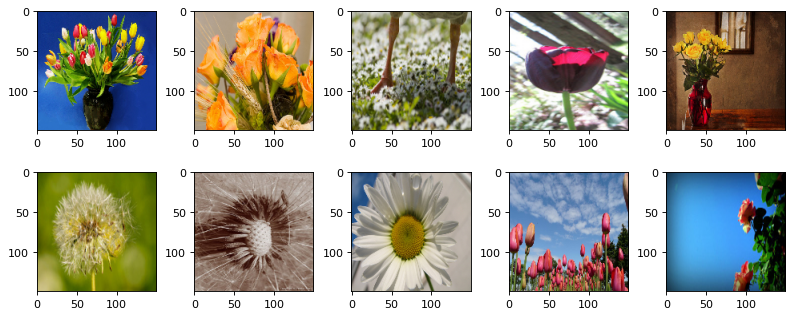

In [10]:
plot_img(train_data,0,(10,10),[0,10],0)

In [28]:
tf.compat.v1.disable_eager_execution()

In [14]:
data_input=tf.compat.v1.placeholder(tf.float32,[None,150,150,3],name="data_input")
label_input=tf.compat.v1.placeholder(tf.float32,[None,classes],name="label_input")

In [15]:
init_var = tf.initializers.glorot_uniform()
weight1=tf.Variable(init_var((5,5,3,16)),name="weight1")
weight2=tf.Variable(init_var((3,3,16,32)),name="weight2")
weight3=tf.Variable(init_var((3,3,32,64)),name="weight3")
weight4=tf.Variable(init_var((3,3,64,128)),name="weight4")
weight5=tf.Variable(init_var((3,3,128,256)),name="weight5")
weight6=tf.Variable(init_var((3,3,256,256)),name="weight6")

In [16]:
convo1=tf.nn.conv2d(data_input,weight1,strides=[1,1,1,1],padding="SAME",name="convo1")
batch_norm1=tf.layers.batch_normalization(convo1,momentum=0.5,name="batch_norm1")
relu1=tf.nn.relu(batch_norm1,name="relu1")
maxpool1=tf.nn.max_pool(relu1,[1,3,3,1],[1,2,2,1],"SAME",name="maxpool1")

convo2=tf.nn.conv2d(maxpool1,weight2,strides=[1,1,1,1],padding="VALID",name="convo2")
batch_norm2=tf.layers.batch_normalization(convo2,momentum=0.5,name="batch_norm2")
relu2=tf.nn.relu(batch_norm2,name="relu2")
maxpool2=tf.nn.max_pool(relu2,[1,2,2,1],[1,2,2,1],"VALID",name="maxpool2")

convo3=tf.nn.conv2d(maxpool2,weight3,strides=[1,1,1,1],padding="VALID",name="convo3")
batch_norm3=tf.layers.batch_normalization(convo3,momentum=0.5,name="batch_norm3")
relu3=tf.nn.relu(batch_norm3,name="relu3")
# drop1=tf.layers.dropout(relu3,rate=0.2)
convo4=tf.nn.conv2d(relu3,weight4,strides=[1,1,1,1],padding="VALID",name="convo4")
batch_norm4=tf.layers.batch_normalization(convo4,momentum=0.5,name="batch_norm4")
relu4=tf.nn.relu(batch_norm4,name="relu4")
maxpool3=tf.nn.max_pool(relu4,[1,2,2,1],[1,1,1,1],"VALID",name="maxpool3")

convo5=tf.nn.conv2d(maxpool3,weight5,strides=[1,1,1,1],padding="VALID",name="convo5")
batch_norm5=tf.layers.batch_normalization(convo5,momentum=0.5,name="batch_norm5")
relu5=tf.nn.relu(batch_norm5,name="relu5")
maxpool4=tf.nn.max_pool(relu5,[1,2,2,1],[1,2,2,1],"VALID",name="maxpool4")
convo6=tf.nn.conv2d(maxpool4,weight6,strides=[1,1,1,1],padding="VALID",name="convo6")
batch_norm6=tf.layers.batch_normalization(convo6,momentum=0.5,name="batch_norm6")
relu6=tf.nn.relu(batch_norm6,name="relu6")

flat=tf.layers.flatten(relu6)
# drop2=tf.layers.dropout(flat,rate=0.2)
dense1=tf.layers.dense(flat,units=800,activation="relu",kernel_initializer=tf.initializers.glorot_uniform(),name="dense1")
dense2=tf.layers.dense(dense1,units=200,activation="relu",kernel_initializer=tf.initializers.glorot_uniform(),name="dense2")
dense3=tf.layers.dense(dense2,units=classes,kernel_initializer=tf.initializers.glorot_uniform(),name="dense3")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:463: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs, training=training)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentati

In [17]:
final_pred=tf.nn.softmax(dense3, name="final_pred")
cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=dense3,labels=label_input)
cost_op=tf.reduce_mean(cross_entropy)
correct_prediction=tf.equal(tf.argmax(final_pred,1),tf.argmax(label_input,1))
accurecy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
grad=tf.train.AdamOptimizer(0.0006).minimize(cost_op)

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,# randomly flip images     
)  


datagen.fit(train_data)

aug_img=datagen.flow(train_data,train_label, batch_size=BATCH_SIZE-10)

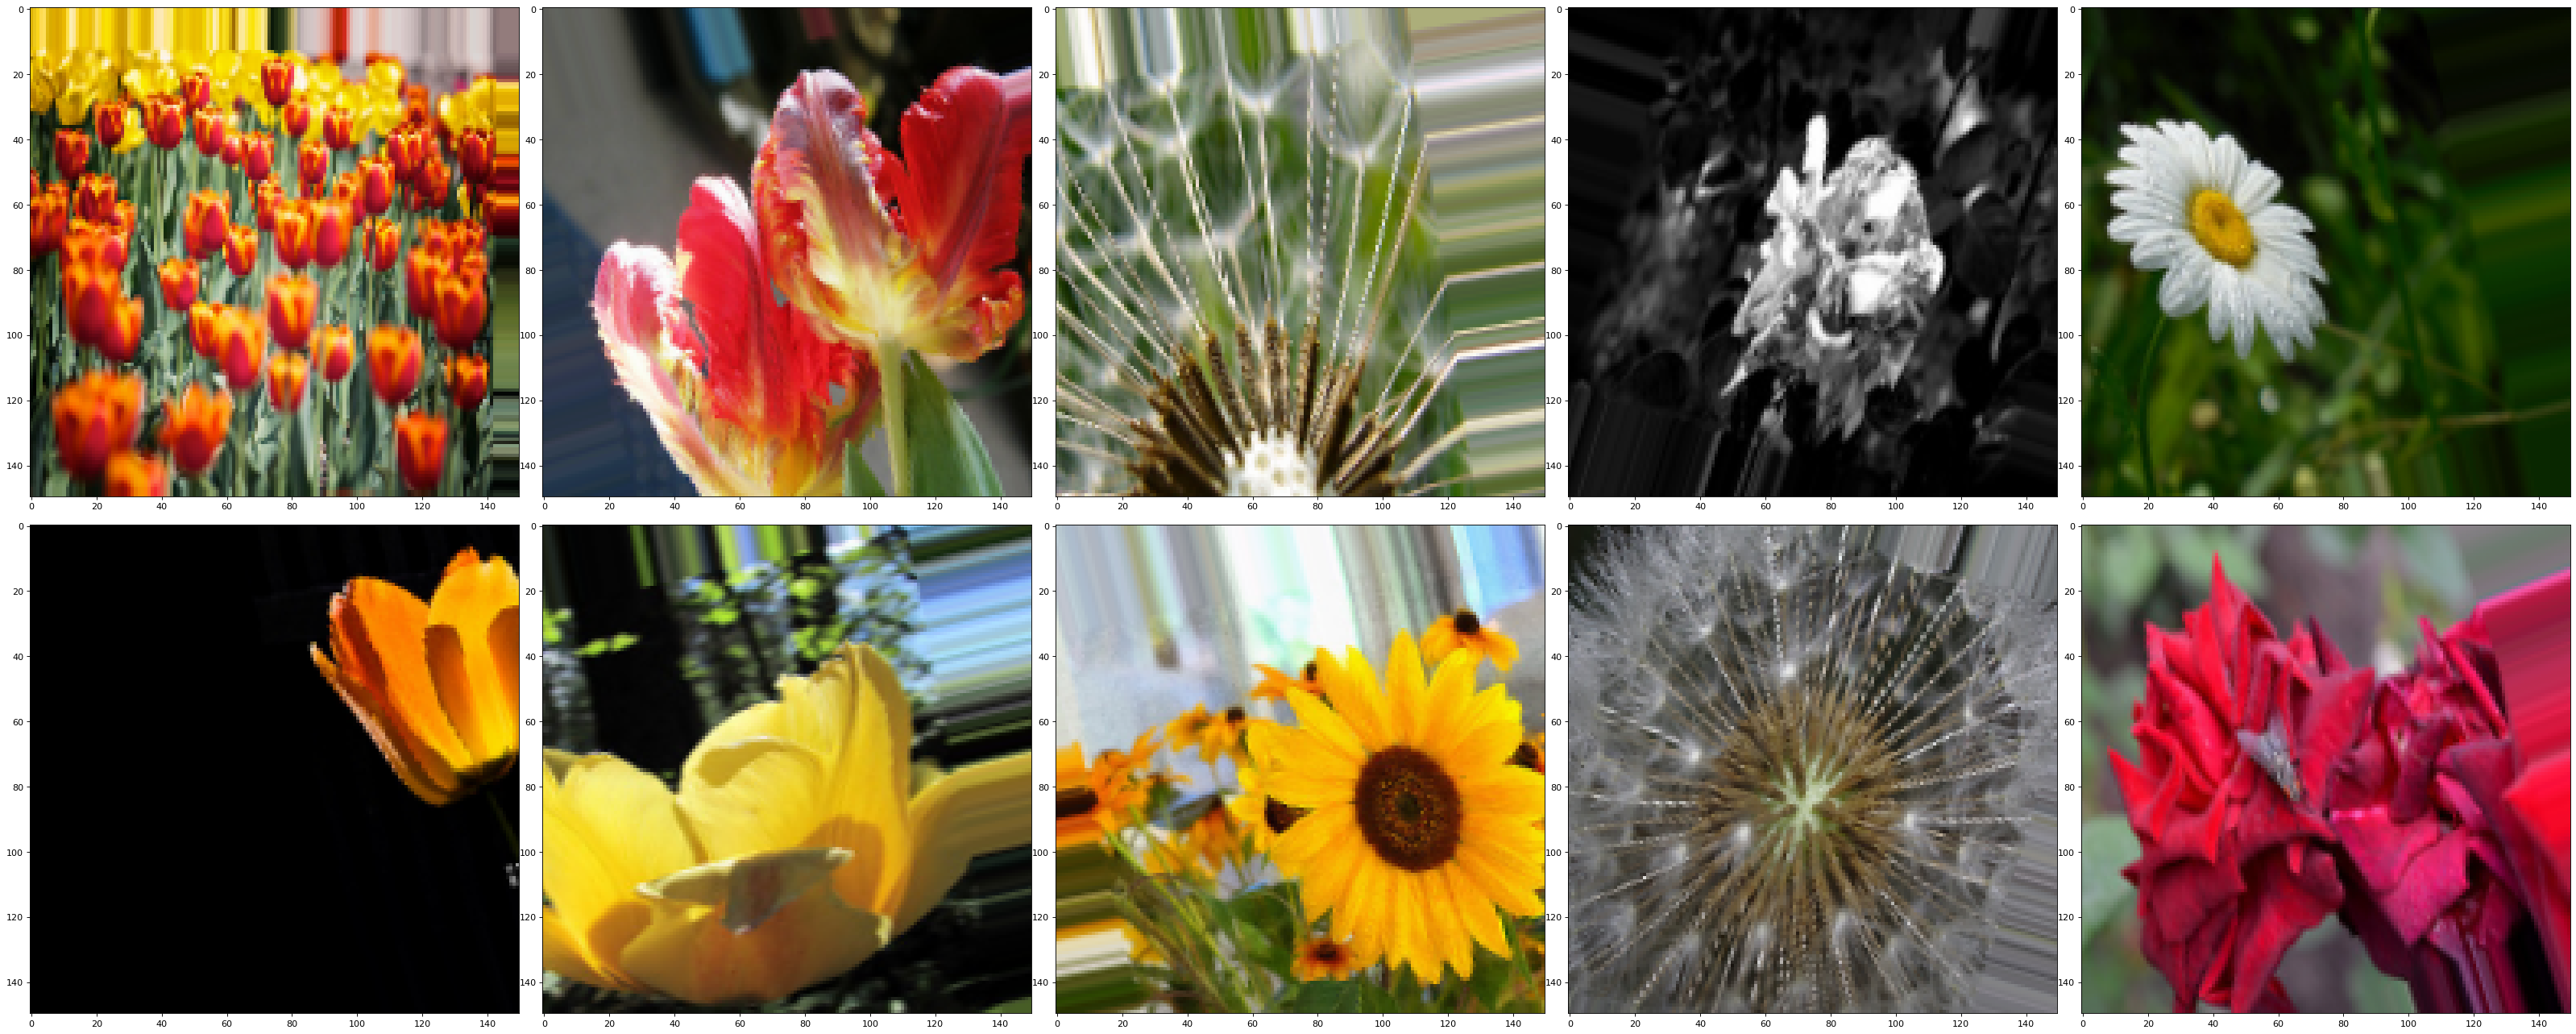

In [19]:
t_data,t_label=next(aug_img)
plot_img(t_data,0,(40,40),[0,10],0)

In [22]:
sess=tf.Session()
saver=tf.train.Saver()
sess.run(tf.global_variables_initializer())
for epoch in range(EPOCH):
    for b_num in range((train_data.shape[0]//BATCH_SIZE)+1):
        t_data,t_label=next(aug_img)
        rand=np.random.randint(low=0,high=train_data.shape[0],size=10)
        temp_data,temp_label=train_data[rand],train_label[rand]
        t_data,t_label=np.vstack((t_data,temp_data)),np.vstack((t_label,temp_label))
        val=sess.run([grad,cost_op,accurecy],feed_dict={data_input:t_data.astype(np.float32),label_input:t_label})
    valid_op_acc=sess.run([cost_op,accurecy],feed_dict={data_input:validation_data,label_input:validation_label})
    print("--------------------------------")
    print("Epoch             : ",epoch+1)
    print("Train Loss        : ",val[1])
    print("Test Loss         : ",valid_op_acc[0])
    print("Train Accuracy    : ",val[2])
    print("Test Accuracy     : ",valid_op_acc[1])       
    print("--------------------------------")
    if val[2]-valid_op_acc[1]<DIFFRENCE or (MAX_TRAIN_ACC<val[2] and MAX_TEST_ACC<valid_op_acc[1]):
        MAX_TEST_ACC=val[2]
        MAX_TRAIN_ACC=valid_op_acc[1]
        DIFFRENCE=val[2]-valid_op_acc[1]
        saver.save(sess,"flower_model_"+str(epoch+1)+"_"+str(MAX_TEST_ACC))
        print("======================================")
        print("============ MODEL SAVED =============")
        print("======================================")

KeyboardInterrupt: ignored

In [23]:
test_img=cv2.imread("/content/flowers/rose/10503217854_e66a804309.jpg")
test_img=cv2.resize(test_img, (IMG_SIZE,IMG_SIZE))

In [24]:
test_img=np.array([cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)])

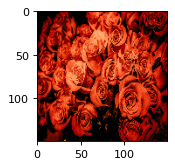

In [25]:
plot_img(test_img,0,(10,10),[0,1],0)

In [29]:
pred_test=sess.run(final_pred,feed_dict={data_input:test_img.astype(np.float32)})
STR_LABEL[np.argmax(pred_test)]

'rose'